In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from enum import Enum
import copy
from scipy.signal import correlate2d

# Here's how animate works
# https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code
# https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.clear_output


In [2]:
class Strategy(Enum):
    c = 0
    d = 1
    s = 2


def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d


class BasicWorld:
    def __init__(
        self,
        n=20,
        m=None,
        u=0.3,
        do_mutation=False,
        do_silent=False,
        bounds=None,
        mutate_rate=0,
        silent_coop=False,
    ):
        """
        bounds is a tuple of (x_start, y_start, x_end, y_end) for a block of
        cooperators among the sea of defectors.
        """

        def agent_at_pos(x, y):
            if bounds is None:
                return Agent(silent_coop=silent_coop)
            else:
                if (bounds[0] < x < bounds[2]) and (bounds[1] < y < bounds[3]):
                    return Agent(strategy=Strategy.c, silent_coop=silent_coop)
                else:
                    return Agent(silent_coop=silent_coop)

        self.curr_step = 0

        self.mutate_rate = mutate_rate

        self.n = n
        if m is None:
            m = self.n
        self.m = m

        self.array = [
            [agent_at_pos(x, y) for x in range(self.m)] for y in range(self.n)
        ]

        self.u = u
        self.kernel = np.array(
            [
                [1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3],
                [1 / 3, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 3],
                [1 / 3, 1 / 2, 1, 1, 1, 1 / 2, 1 / 3],
                [1 / 3, 1 / 2, 1, -u, 1, 1 / 2, 1 / 3],
                [1 / 3, 1 / 2, 1, 1, 1, 1 / 2, 1 / 3],
                [1 / 3, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 3],
                [1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3],
            ]
        )

        self.inherent_fitness_increment_prob = 0.001
        self.inherent_fitness_increment_amt = 0.1
        self.normalization_constant = 24 * (1 + self.u)

    def make_pd_results(self):
        """
        Makes an n x m array, where elements are the fitnesses that agents get
        from playing the PD, both from defecting and from having others
        cooperate with them.  Boundary conditions are periodic, i.e. agents at
        the far left play against agents at the far right.
        """
        coop_array = np.array(
            [
                [1 if agent.cooperate_p(self.curr_step) else 0 for agent in row]
                for row in self.array
            ]
        )

        pd_results = correlate2d(coop_array, self.kernel, mode="same", boundary="wrap")
        return pd_results

    def make_fitness_array(self):
        """
        Makes an n x m array, where each element is that agent's fitness,
        derived from its and others' behaviors and their inherent fitnesses.
        """
        inherent_fitnesses = np.array(
            [[agent.inherent_fitness for agent in row] for row in self.array]
        )
        pd_results = self.make_pd_results()
        return pd_results + inherent_fitnesses

    def step(self):
        """
        Runs a step of the simulation.
        * Calculate fitness of each agent
        * Figure out who conquers whom, and let them conquer
        * Randomly increment inherent fitnesses
        """
        # make fitness array
        arr = self.make_fitness_array()

        # determine who conquers whom in the local area
        # ORIGINAL IMPLEMENTATION:
        # for "conquering", we look at every cell in a random order
        # after picking a cell we then look at ONE OF the four "direct" neighbors (cardinal directions)
        # we compare fitnesses. If our current cell is higher, do nothing.
        # If our current cell has lower fitness we can be replaced with the other cell

        conquering_pairs = []  # Pairs of (conqueror, to_be_conquered)
        locs = [(x, y) for x in range(self.m) for y in range(self.m)]
        np.random.shuffle(locs)
        for x, y in locs:
            cells_to_compare = [
                ((x - 1) % self.m, y),
                ((x + 1) % self.m, y),
                (x, (y - 1) % self.n),
                (x, (y + 1) % self.n),
            ]
            look_loc = cells_to_compare[np.random.randint(4)]

            invader_val = arr[look_loc[0]][look_loc[1]]
            curr_val = arr[x][y]

            if invader_val > curr_val:
                if (
                    invader_val - curr_val
                ) / self.normalization_constant > np.random.rand(1, 1):
                    conquering_pairs.append((look_loc, (x, y)))

        # have conquering happen [update matrices/agents] -> mutation at odds mut_chance or whatever
        for x in conquering_pairs:
            conqueror_loc = x[0]
            conquered_loc = x[1]
            self.array[conquered_loc[0]][conquered_loc[1]] = copy.deepcopy(
                self.array[conqueror_loc[0]][conqueror_loc[1]]
            )
            self.array[conquered_loc[0]][conquered_loc[1]].mutate(
                mutate_rate=self.mutate_rate, curr_step=self.curr_step
            )

        # Increment random inherent_fitness vars
        for agent in [agent for row in self.array for agent in row]:
            if np.random.random() < self.inherent_fitness_increment_prob:
                agent.inherent_fitness += self.inherent_fitness_increment_amt

        self.curr_step += 1

        return

    def draw_array(self, array, **options):
        """Draws the cells."""
        n, m = array.shape
        options = underride(
            options,
            cmap="Greens",
            alpha=0.7,
            vmin=0,
            vmax=1,
            interpolation="none",
            origin="upper",
            extent=[0, m, 0, n],
        )

        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        return plt.imshow(array, **options)

    def draw(self, interval=None, step=None):
        """
        Gets the current np array state then draws the array
        """
        arr = np.asarray(
            [[agent.strategy.value for agent in row] for row in self.array]
        )
        self.draw_array(arr)

    def animate(self, frames, interval=None, skip=0, step=None):
        """Animate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """
        if step is None:
            step = self.step

        if interval is None:
            interval = 0.01

        plt.figure()
        try:
            for i in range(frames - 1):
                self.draw()
                # plt.show(block=False)
                plt.pause(interval)
                for _ in range(skip + 1):
                    step()
                plt.clf()
                # clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

    def get_stats(self):
        """
        Get some summary statistics that might be useful for graphing.  Stats
        are returned as a dict.
        Stats are:
        * "time" : current timestep
        * "num_c", "num_d", "num_s": Number of agents in each state
        TODO: Should we refactor this so it returns lists or something?
        """

        stats = {"time": self.curr_step}

        def count_strat(s):
            return np.sum(
                [
                    (1 if agent.strategy == s else 0)
                    for row in self.array
                    for agent in row
                ]
            )

        stats["num_c"] = count_strat(Strategy.c)
        stats["num_d"] = count_strat(Strategy.d)
        stats["num_s"] = count_strat(Strategy.s)

        return stats


class Agent:
    def __init__(self, strategy=Strategy.d, silent_coop=False):

        self.silent_coop_chance = 1E-2
        self.inherent_fitness = 0
        self.strategy = strategy
        self.coop_valid = silent_coop

        if silent_coop:
            if np.random.random() < self.silent_coop_chance:
                self.silent_coop = True
                self.time_to_cooperate = int(np.random.exponential(200))
                self.strategy= Strategy.s
                print(self.time_to_cooperate)
            else:
                self.time_to_cooperate = None
                self.silent_coop = False
        else:
            self.time_to_cooperate = None
            self.silent_coop = False

    def __tostr__(self):
        return str(self.strategy)


    def cooperate_p(self, t):
        if self.strategy == Strategy.c:
            return True
        if self.strategy == Strategy.d:
            return False
        if self.strategy == Strategy.s:
            return self.time_to_cooperate < t

    def mutate(self, mutate_rate, curr_step):
        """
        Placeholder function; fort the first type of world we do not have a mutate function,
        so we will come back to implmenet later
        """
        num = np.random.rand()
        if num < mutate_rate:
            if self.coop_valid:
                self.strategy = Strategy.s
                self.time_to_cooperate = int(np.random.exponential(200)) + curr_step
                print("that worked?!", self.time_to_cooperate)
            else:
                if self.strategy == Strategy.d:
                    self.strategy = Strategy.c


158
1146
233
0
75
192
8
133
72
175
4
126
197
8
53
70
617
539
415
93
208
69
146
66
194
48
102
141
308
44
that worked?! 224
that worked?! 337
that worked?! 391
that worked?! 386
that worked?! 419
that worked?! 483
that worked?! 442
that worked?! 927
that worked?! 610
that worked?! 647
that worked?! 618
that worked?! 591
that worked?! 1234
that worked?! 853
that worked?! 829
that worked?! 751
that worked?! 888
that worked?! 859
that worked?! 1339
that worked?! 899
that worked?! 1028
that worked?! 938
that worked?! 1266
that worked?! 1246
that worked?! 1372
that worked?! 1759
that worked?! 1105
that worked?! 1172
that worked?! 1219
that worked?! 1613
that worked?! 1243
that worked?! 1301
that worked?! 1235
that worked?! 1234
that worked?! 1544
that worked?! 1558
that worked?! 1327
that worked?! 1324
that worked?! 1806
that worked?! 1531
that worked?! 1327
that worked?! 1870
that worked?! 1320
that worked?! 1540
that worked?! 1376
that worked?! 1414
that worked?! 1792
that worked?! 1444
tha

that worked?! 3322
that worked?! 3282
that worked?! 3438
that worked?! 3211
that worked?! 3214
that worked?! 3198
that worked?! 3204
that worked?! 3265
that worked?! 3252
that worked?! 3396
that worked?! 3566
that worked?! 3601
that worked?! 3495
that worked?! 3326
that worked?! 3554
that worked?! 3210
that worked?! 3342
that worked?! 3262
that worked?! 3354
that worked?! 3257
that worked?! 3314
that worked?! 3255
that worked?! 3289
that worked?! 3259
that worked?! 3407
that worked?! 3270
that worked?! 3524
that worked?! 3531
that worked?! 3380
that worked?! 3513
that worked?! 3322
that worked?! 3336
that worked?! 3445
that worked?! 3436
that worked?! 3352
that worked?! 3326
that worked?! 3674
that worked?! 3373
that worked?! 3680
that worked?! 3296
that worked?! 3346
that worked?! 3506
that worked?! 3450
that worked?! 3696
that worked?! 3549
that worked?! 3530
that worked?! 3420
that worked?! 3475
that worked?! 3508
that worked?! 3358
that worked?! 3364
that worked?! 3555
that worked?

that worked?! 4510
that worked?! 4706
that worked?! 4651
that worked?! 4479
that worked?! 4543
that worked?! 4818
that worked?! 4496
that worked?! 4858
that worked?! 4539
that worked?! 4737
that worked?! 4640
that worked?! 4672
that worked?! 4618
that worked?! 4801
that worked?! 4663
that worked?! 4622
that worked?! 4640
that worked?! 4549
that worked?! 4521
that worked?! 4806
that worked?! 4592
that worked?! 4704
that worked?! 4569
that worked?! 4880
that worked?! 4576
that worked?! 4819
that worked?! 4660
that worked?! 4749
that worked?! 4669
that worked?! 5336
that worked?! 4636
that worked?! 4621
that worked?! 4573
that worked?! 4639
that worked?! 4658
that worked?! 4658
that worked?! 4677
that worked?! 4702
that worked?! 4768
that worked?! 4768
that worked?! 4771
that worked?! 4816
that worked?! 4674
that worked?! 4771
that worked?! 4739
that worked?! 5069
that worked?! 4836
that worked?! 4663
that worked?! 4694
that worked?! 4805
that worked?! 5228
that worked?! 4731
that worked?

that worked?! 7108
that worked?! 7030
that worked?! 6742
that worked?! 6684
that worked?! 6868
that worked?! 6852
that worked?! 7009
that worked?! 6937
that worked?! 6778
that worked?! 7248
that worked?! 6724
that worked?! 6858
that worked?! 6724
that worked?! 6770
that worked?! 6781
that worked?! 6809
that worked?! 6772
that worked?! 7040
that worked?! 6818
that worked?! 7033
that worked?! 6988
that worked?! 6782
that worked?! 6789
that worked?! 7333
that worked?! 7118
that worked?! 6839
that worked?! 6886
that worked?! 6795
that worked?! 6924
that worked?! 6812
that worked?! 6854
that worked?! 6918
that worked?! 7019
that worked?! 7032
that worked?! 6936
that worked?! 6899
that worked?! 7263
that worked?! 6901
that worked?! 6906
that worked?! 6947
that worked?! 7182
that worked?! 6987
that worked?! 7491
that worked?! 8060
that worked?! 6915
that worked?! 6962
that worked?! 7002
that worked?! 6965
that worked?! 7054
that worked?! 7514
that worked?! 7218
that worked?! 7355
that worked?

that worked?! 9899
that worked?! 10086
that worked?! 10655
that worked?! 9884
that worked?! 10436
that worked?! 10006
that worked?! 10133
that worked?! 10060
that worked?! 10527
that worked?! 9919
that worked?! 10067
that worked?! 10023
that worked?! 10070
that worked?! 10230
that worked?! 10337
that worked?! 9982
that worked?! 10213
that worked?! 10098
that worked?! 9946
that worked?! 9976
that worked?! 9965
that worked?! 10092
that worked?! 10214
that worked?! 10152


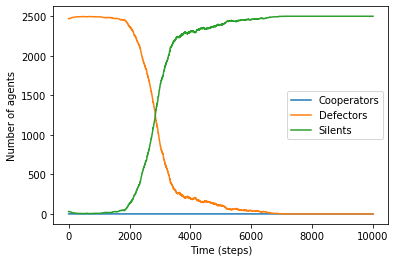

In [3]:
mutate_rate = 1e-2
# world = BasicWorld(n=40, mutate_rate=mutate_rate, bounds=(18, 18, 22, 22), silent_coop=False)
world = BasicWorld(n=50, mutate_rate=mutate_rate, silent_coop=True)


stats = {"time": [], "num_c": [], "num_d": [], "num_s": []}
for _ in range(10000):
    world.step()
    for key, value in world.get_stats().items():
        stats[key].append(value)

plt.plot(stats["time"], stats["num_c"], label="Cooperators")
plt.plot(stats["time"], stats["num_d"], label="Defectors")
plt.plot(stats["time"], stats["num_s"], label="Silents")

plt.xlabel("Time (steps)")
plt.ylabel("Number of agents")
plt.legend()
plt.show()
